In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('ggplot')

from mixedbridge.stochastic_processes.examples import BrownianProcess, BrownianAuxProcess, BrownianBridgeProcess
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess
from mixedbridge.solvers.sde import WienerProcess, Euler, ModifiedEuler
from mixedbridge.utils.plotting import plot_sample_path, plot_sample_path_histogram

### Brownian bridges

#### Path evaluation

In [90]:
dim = 1
T = 1.0
dt = 1. / 500
dtype = jnp.float32

gamma = 2.0
sigma = 1.0

rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.0], dtype=dtype)
v  = jnp.array([0.0], dtype=dtype)
t_scheme = "linear"

wiener_proc = WienerProcess(T=T, dt=dt, dim=dim, dtype=dtype, t_scheme=t_scheme)
bridge_proc = BrownianBridgeProcess(
    gamma=gamma,
    sigma=sigma,
    v=v,
    T=T,
    dim=dim
)

bridge_solver = ModifiedEuler(bridge_proc, wiener_proc)

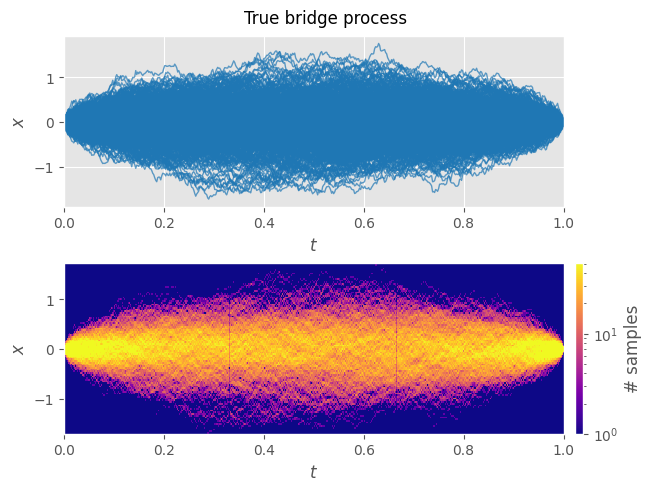

In [97]:
bridge_path = bridge_solver.solve(x0, rng_key, batch_size=512, enforce_end_point=v)

fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained")
plot_sample_path(bridge_path, plot_object="xs", ax=ax1, colors=("tab:blue",))
plot_sample_path_histogram(bridge_path, plot_object="xs", ax=ax2, vertical_bins=100)
fig.suptitle(f"True bridge process")
plt.show()

In [98]:
ori_proc           = BrownianProcess(gamma=gamma, sigma=sigma, T=T, dim=dim, dtype=dtype)
aux_proc           = BrownianAuxProcess(gamma=0.0, sigma=sigma, T=T, dim=dim, dtype=dtype)
guided_bridge_proc = GuidedBridgeProcess(ori_proc=ori_proc, 
                                         aux_proc=aux_proc, 
                                         x0=x0,
                                         v=v,
                                         L0=jnp.eye(dim, dtype=dtype), 
                                         Sigma0=jnp.eye(dim, dtype=dtype)*1e-10,
                                         ts=wiener_proc.ts)

guided_bridge_solver = ModifiedEuler(guided_bridge_proc, wiener_proc)

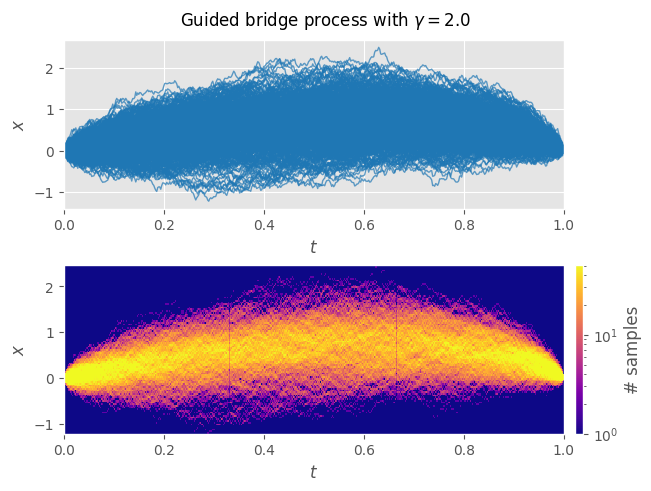

In [99]:
guided_bridge_path = guided_bridge_solver.solve(x0, rng_key, batch_size=512, enforce_end_point=v)

fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained")
plot_sample_path(guided_bridge_path, plot_object="xs", ax=ax1, colors=("tab:blue",))
plot_sample_path_histogram(guided_bridge_path, plot_object="xs", ax=ax2, vertical_bins=100)
fig.suptitle(f"Guided bridge process with $\gamma={gamma}$")
plt.show()

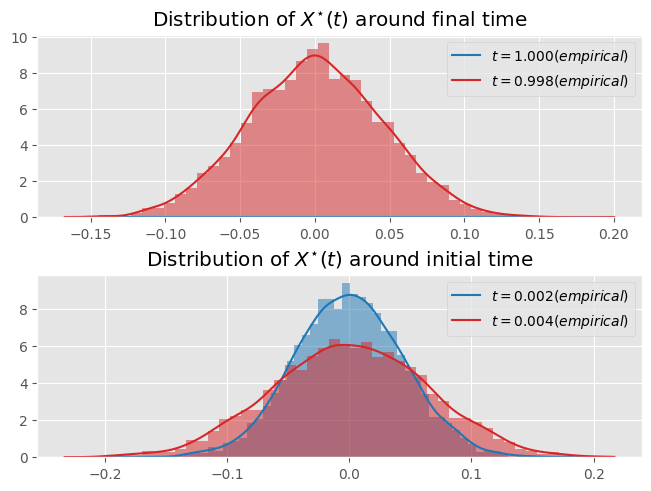

In [80]:
bridge_path = bridge_solver.solve(x0, rng_key, batch_size=4096)
ts = bridge_path.ts
xs = bridge_path.xs

last_step_xs = xs[:, -1, :]
last_two_step_xs = xs[:, -2, :]

first_step_xs = xs[:, 1, :]
first_two_step_xs = xs[:, 2, :]

# Compute kernel density estimates
kde_last = stats.gaussian_kde(last_step_xs.flatten())
kde_last_two = stats.gaussian_kde(last_two_step_xs.flatten())

kde_first = stats.gaussian_kde(first_step_xs.flatten())
kde_first_two = stats.gaussian_kde(first_two_step_xs.flatten())

true_marginal = lambda t, x: stats.norm.pdf(x, loc=0.0, scale=t*(T-t)/T)


fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained")
x_range = jnp.linspace(min(last_step_xs.min(), last_two_step_xs.min()), 
                      max(last_step_xs.max(), last_two_step_xs.max()), 
                      200)
# empirical
ax1.plot(x_range, kde_last(x_range), label=fr"$t={ts[-1]:.3f} (empirical)$", color="tab:blue")
# ax1.hist(last_step_xs.flatten(), density=True, bins=50, alpha=0.5)
ax1.plot(x_range, kde_last_two(x_range), label=fr"$t={ts[-2]:.3f} (empirical)$", color="tab:red")
ax1.hist(last_two_step_xs.flatten(), density=True, bins=50, alpha=0.5, color="tab:red")
# true
# ax1.plot(x_range, true_marginal(ts[-1], x_range), label=fr"$t={ts[-1]:.3f} (true)$", color="tab:blue", ls="--")
# ax1.plot(x_range, true_marginal(ts[-2], x_range), label=fr"$t={ts[-2]:.3f} (true)$", color="tab:red", ls="--")
ax1.set_title(r"Distribution of $X^{\star}(t)$ around final time")
ax1.legend()

x_range = jnp.linspace(min(first_step_xs.min(), first_two_step_xs.min()), 
                      max(first_step_xs.max(), first_two_step_xs.max()), 
                      200)
# empirical
ax2.plot(x_range, kde_first(x_range), label=fr"$t={ts[1]:.3f} (empirical)$", color="tab:blue")
ax2.hist(first_step_xs.flatten(), density=True, bins=50, alpha=0.5, color="tab:blue")
ax2.plot(x_range, kde_first_two(x_range), label=fr"$t={ts[2]:.3f} (empirical)$", color="tab:red")
ax2.hist(first_two_step_xs.flatten(), density=True, bins=50, alpha=0.5, color="tab:red")
# true
# ax2.plot(x_range, true_marginal(ts[1], x_range), label=fr"$t={ts[1]:.3f} (true)$", color="tab:blue", ls="--")
# ax2.plot(x_range, true_marginal(ts[2], x_range), label=fr"$t={ts[2]:.3f} (true)$", color="tab:red", ls="--")
ax2.set_title(r"Distribution of $X^{\star}(t)$ around initial time")
ax2.legend()
plt.show()


### Brownian motions

In [65]:
dim = 1
T = 1.0
dt = 1. / 500
dtype = jnp.float32

gamma = 0.0
sigma = 1.0

rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.0], dtype=dtype)
v  = jnp.array([0.0], dtype=dtype)
t_scheme = "linear"

wiener_proc  = WienerProcess(T=T, dt=dt, dim=dim, dtype=dtype, t_scheme=t_scheme)
brownian_proc = BrownianProcess(
    gamma=gamma,
    sigma=sigma,
    T=T,
    dim=dim
)

brownian_solver = Euler(brownian_proc, wiener_proc)

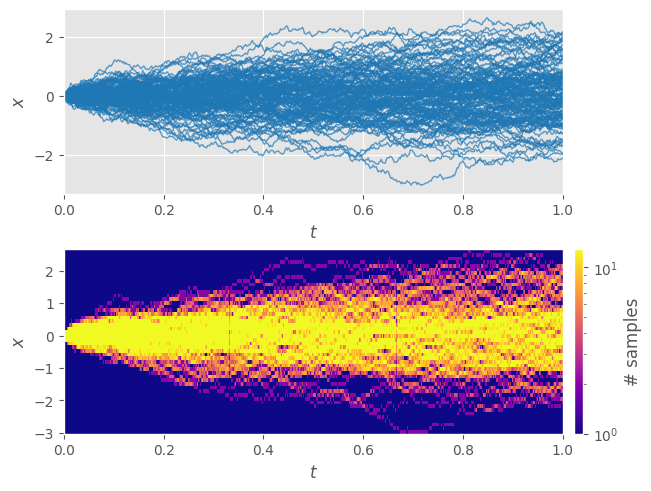

In [66]:
brownian_path = brownian_solver.solve(x0, rng_key, batch_size=128)

fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained")
plot_sample_path(brownian_path, plot_object="xs", ax=ax1, colors=("tab:blue",))
plot_sample_path_histogram(brownian_path, plot_object="xs", ax=ax2, vertical_bins=50)
plt.show()

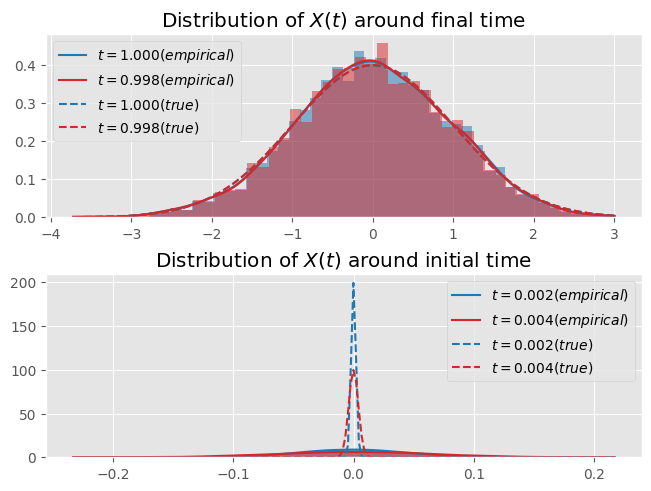

In [77]:
brownian_path = brownian_solver.solve(x0, rng_key, batch_size=4096)
ts = brownian_path.ts
xs = brownian_path.xs

last_step_xs = xs[:, -1, :]
last_two_step_xs = xs[:, -2, :]

first_step_xs = xs[:, 1, :]
first_two_step_xs = xs[:, 2, :]

# Compute kernel density estimates
kde_last = stats.gaussian_kde(last_step_xs.flatten())
kde_last_two = stats.gaussian_kde(last_two_step_xs.flatten())

kde_first = stats.gaussian_kde(first_step_xs.flatten())
kde_first_two = stats.gaussian_kde(first_two_step_xs.flatten())

true_marginal = lambda t, x: stats.norm.pdf(x, loc=0.0, scale=t)

# Generate points to evaluate the density
x_range = jnp.linspace(min(last_step_xs.min(), last_two_step_xs.min()), 
                      max(last_step_xs.max(), last_two_step_xs.max()), 
                      200)

fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained")
# empirical
ax1.plot(x_range, kde_last(x_range), label=fr"$t={ts[-1]:.3f} (empirical)$", color="tab:blue")
ax1.hist(last_step_xs.flatten(), density=True, bins=50, alpha=0.5, color="tab:blue")
ax1.plot(x_range, kde_last_two(x_range), label=fr"$t={ts[-2]:.3f} (empirical)$", color="tab:red")
ax1.hist(last_two_step_xs.flatten(), density=True, bins=50, alpha=0.5, color="tab:red")
# true
ax1.plot(x_range, true_marginal(ts[-1], x_range), label=fr"$t={ts[-1]:.3f} (true)$", color="tab:blue", ls="--")
ax1.plot(x_range, true_marginal(ts[-2], x_range), label=fr"$t={ts[-2]:.3f} (true)$", color="tab:red", ls="--")
ax1.set_title(r"Distribution of $X(t)$ around final time")
ax1.legend()

x_range = jnp.linspace(min(first_step_xs.min(), first_two_step_xs.min()), 
                      max(first_step_xs.max(), first_two_step_xs.max()), 
                      200)

# empirical
ax2.plot(x_range, kde_first(x_range), label=fr"$t={ts[1]:.3f} (empirical)$", color="tab:blue")
ax2.hist(first_step_xs.flatten(), density=True, bins=50, alpha=0.5, color="tab:blue")
ax2.plot(x_range, kde_first_two(x_range), label=fr"$t={ts[2]:.3f} (empirical)$", color="tab:red")
ax2.hist(first_two_step_xs.flatten(), density=True, bins=50, alpha=0.5, color="tab:red")
# true
ax2.plot(x_range, true_marginal(ts[1], x_range), label=fr"$t={ts[1]:.3f} (true)$", color="tab:blue", ls="--")
ax2.plot(x_range, true_marginal(ts[2], x_range), label=fr"$t={ts[2]:.3f} (true)$", color="tab:red", ls="--")
ax2.set_title(r"Distribution of $X(t)$ around initial time")
ax2.legend()

plt.show()